In [1]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
import time
import util
from keras.models import Model
from keras.layers import Dense
from keras.layers import LSTM, Input

import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split


In [2]:

precision = 0.005  # m/z precision for raw data
data_per_sec = 2  # spectrum per second
half_time_window = 30  # time range before and after RT in sec
number_ticks = half_time_window * 2 * data_per_sec  # number of spectrum per data
intensity_treshold = 8000 #  everything under this will be annotated false
number_sample = 120


data_folder = '../data/sara_training/'

peak_clarkii= data_folder + 'clarkii_peaks_YES_NO_600_cleaned.csv' # data with peak: mz, rt, Y/N
mz_clarkii = data_folder + 'clarkii T0I1.mzML'

peak_viridis= data_folder + 'viridis_BEHamide_YN.csv' # data with peak: mz, rt, Y/N
mz_viridis = data_folder + 'viridisT0I2.mzML'

pickle_path = './output/pickle_training.npy'

In [3]:

data_clark = util.build_data_ml(peak_clarkii,mz_clarkii )
data_viri = util.build_data_ml(peak_viridis,mz_viridis )

all_data = [None,None,None,None]
all_data[0] = data_clark[0] + data_viri[0]
all_data[1] = data_clark[1] + data_viri[1]
all_data[2] = data_clark[2] + data_viri[2]
all_data[3] = data_clark[3] + data_viri[3]

with open(pickle_path, 'wb') as fi:
    np.save(fi, np.asanyarray(all_data, dtype=object))

50
100
150
200
250
300
350
400
450
500
550
600
50
100
150
200
250
300
350


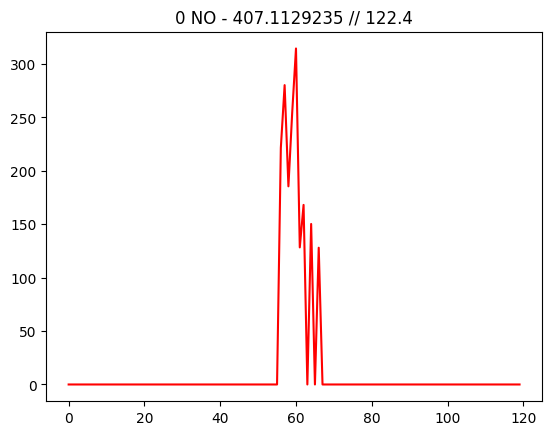

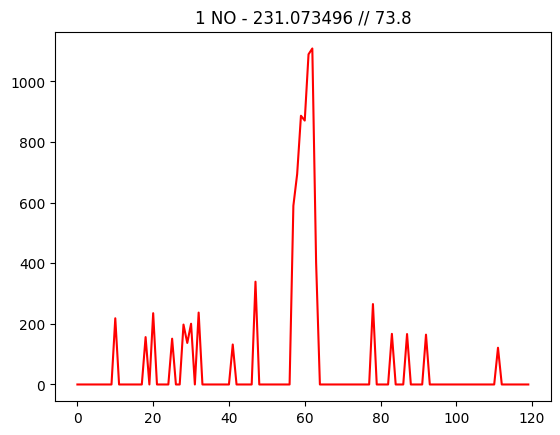

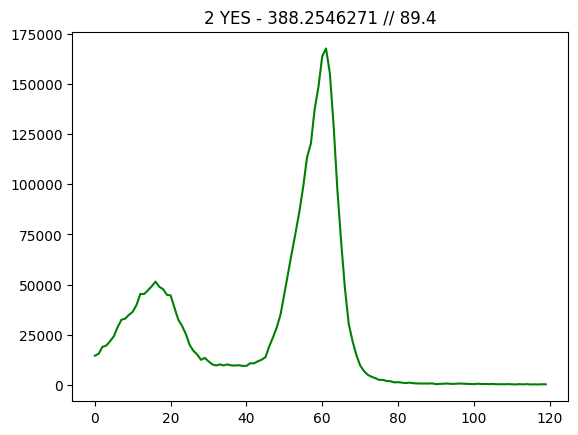

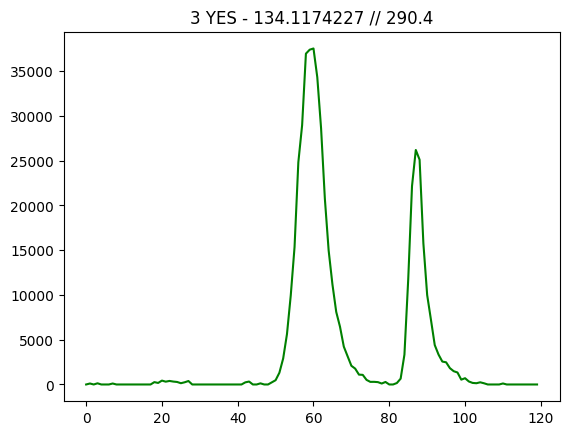

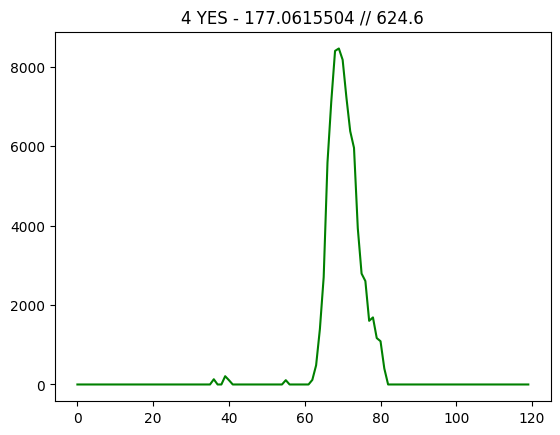

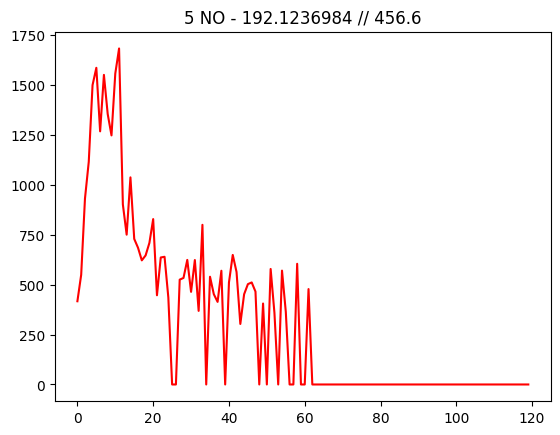

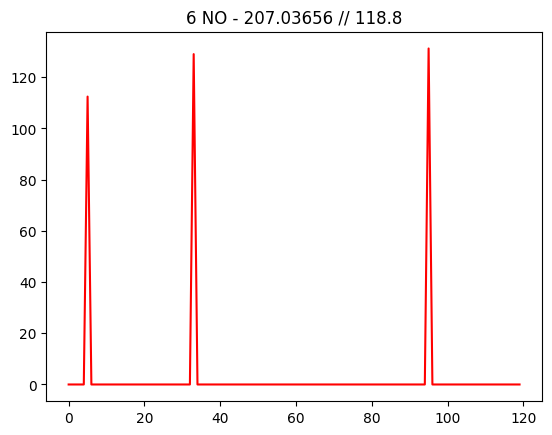

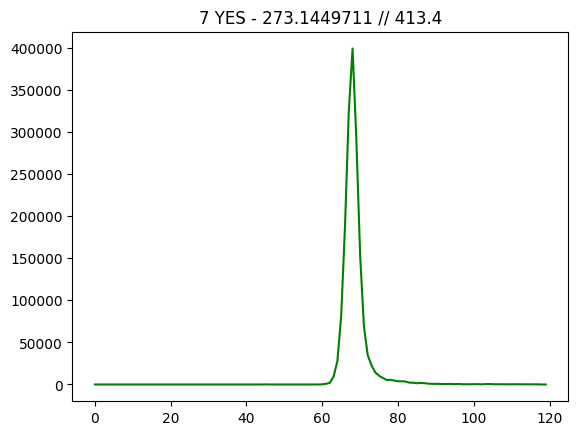

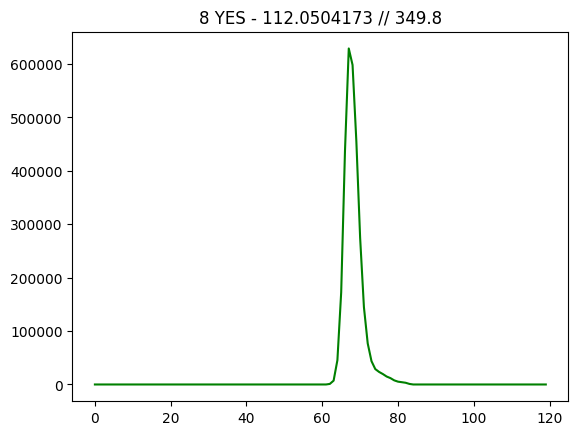

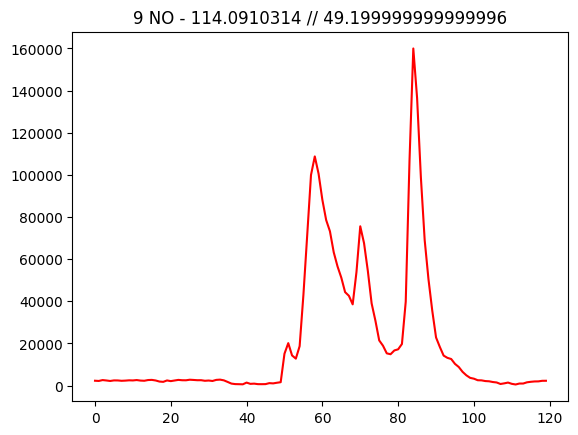

In [4]:
data = np.load(pickle_path, allow_pickle=True)


X_ = data[0]
y_ =  data[1]
mz_ = data[2]
rt_ =  data[3]


for i in range(len(X_))[:10]:
    color = 'green' if y_[i] == 1 else 'red'
    yn = 'YES' if y_[i] == 1 else 'NO'
    plt.title(  str(i) + ' ' + yn + ' - ' + str(mz_[i]) + ' // ' + str(float(rt_[i])))
    plt.plot(X_[i], color=color)
    plt.show()


In [5]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.

    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    input:
        x: the input signal
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal

    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)

    see also:

    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """


    if window_len<3:
        return x


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y


def NormalizeData(data):
    if np.max(data) - np.min(data) == 0.0:
        return data
    return (data - np.min(data)) / (np.max(data) - np.min(data))


def getStat(data):
    s = [0, 0, 0, 0, 0]  # nbrObs, mean, var,skew, kurtosis

    if len(data) > 0:
        de = scipy.stats.describe(data)
        s = [de[0]/number_sample, de[2], de[3], de[4], de[5]]

    return np.nan_to_num(np.array(s))


def filter_threshold(values):
    if max(values) >= intensity_treshold:
        return True
    return False



In [6]:
df = pd.DataFrame(X_)

df['y']= y_
df['mz']= mz_
df['rt']= rt_


df = df[df[0].map(lambda  x: filter_threshold(x))]

df['y'] = df['y'].apply(lambda x: 1 if x == True else 0)

df['norm'] = df[0].apply(lambda x: NormalizeData(x) )

df['smooth'] = df['norm'].apply(lambda x: smooth(x) )
df['smooth'] = df['smooth'].apply(lambda x: x[5:-5] )

df['grad1'] = df['smooth'].apply(lambda x: np.gradient(x) )
df['grad2'] = df['grad1'].apply(lambda x: np.gradient(x) )


# Maxima & Minima
df['maxima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(x, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )
df['minima'] = df['smooth'].apply(lambda x: scipy.signal.find_peaks(-x, height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)[0] )

df['maxval'] =  df[['smooth', 'maxima']].apply(lambda x: [x.smooth[i] for i in x.maxima], axis=1)
df['minval'] =  df[['smooth', 'minima']].apply(lambda x: [x.smooth[i] for i in x.minima], axis=1)

df['maxvalnorm'] =  df['maxval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )
df['minvalnorm'] =  df['minval'].apply(lambda x: NormalizeData(x) if len(x) > 0 else [] )

# Stats
df['maxvalstats'] =  df['maxvalnorm'].apply(lambda x: getStat(x) )
df['minvalstats'] =  df['minvalnorm'].apply(lambda x: getStat(x) )

df['maximastats'] =  df['maxima'].apply(lambda x: getStat(x) )
df['minimastats'] =  df['minima'].apply(lambda x: getStat(x) )

df['stats'] =  df['smooth'].apply(lambda x: getStat(x) )

df['fft'] = df[0].apply(lambda x: np.fft.fft(x) )
df['fftr'] = df['fft'].apply(lambda x: np.real(x) )
df['ffti'] = df['fft'].apply(lambda x: np.real(np.imag(x)) )

/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_76209/387102538.py:59: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  de = scipy.stats.describe(data)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1556: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  sk = skew(a, axis, bias=bias)
/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/scipy/stats/_stats_py.py:1557: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(a, axis, bias=bias)
/var/folders/wn/7gdt_pjn02j1w8_73ql8mp880000gn/T/ipykernel_76209/387102538.py:59: Run

In [7]:
df

,0,y,mz,rt,norm,smooth,grad1,grad2,maxima,minima,...,maxvalnorm,minvalnorm,maxvalstats,minvalstats,maximastats,minimastats,stats,fft,fftr,ffti
2,"[14512.8212890625, 15471.5283203125, 18927.275...",1,388.254627,89.4,"[0.08571052226425582, 0.09143104289394773, 0.1...","[0.10045765720047004, 0.10275005962784373, 0.1...","[0.002292402427373691, 0.004549744582625789, 0...","[0.0022573421552520984, 0.0033041514521843264,...","[16, 60, 95]","[37, 92, 117]",...,"[0.320897760751157, 1.0, 0.0]","[1.0, 0.029500706749812325, 0.0]","[0.025, 0.44029925358371896, 0.260692537367983...","[0.025, 0.34316690224993746, 0.323789861649642...","[0.025, 57.0, 1567.0, -0.13842741276879447, -1.5]","[0.025, 82.0, 1675.0, -0.4220804429649462, -1....","[1.0, 0.15474159115798744, 0.04735065173319348...","[(3128577.0594177246+0j), (-1334907.3012342255...","[3128577.0594177246, -1334907.3012342255, 1611...","[0.0, -879171.2533476867, -367927.44320833404,..."
3,"[0, 109.23646545410156, 0, 130.23809814453125,...",1,134.117423,290.4,"[0.0, 0.0029103146279069935, 0.0, 0.0034698471...","[0.0015324828115442575, 0.0014835051340023843,...","[-4.897767754187326e-05, -8.86014510182644e-05...","[-3.962377347639114e-05, -4.995483691064344e-0...","[22, 43, 59, 87]","[12, 34, 46, 79]",...,"[0.006048308052433592, 0.0, 1.0, 0.54750323593...","[0.0, 0.0, 0.48966964599666357, 1.0]","[0.03333333333333333, 0.38838788599706325, 0.2...","[0.03333333333333333, 0.3724174114991659, 0.22...","[0.03333333333333333, 52.75, 750.9166666666666...","[0.03333333333333333, 42.75, 782.25, 0.3153141...","[1.0, 0.10818219049825424, 0.04585310533107903...","[(487235.67504119873+0j), (-343772.15341900906...","[487235.67504119873, -343772.15341900906, 1789...","[0.0, 136215.4095432649, -21500.875264179896, ..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,177.06155,624.6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[39, 55, 69]","[47, 58]",...,"[0.006450017031211586, 0.0, 1.0]","[0.0, 1.0]","[0.025, 0.3354833390104039, 0.3311971952294971...","[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.025, 54.333333333333336, 225.33333333333331...","[0.016666666666666666, 52.5, 60.5, 0.0, -2.0]","[1.0, 0.07667060420216343, 0.04231692491049383...","[(77865.11724090576+0j), (-64991.90851401366+3...","[77865.11724090576, -64991.90851401366, 32680....","[0.0, 39149.77058196768, -63233.24215895787, 6..."
7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,273.144971,413.4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[45, 68, 103]","[52, 100]",...,"[0.0, 1.0, 0.0014222482996333519]","[0.0, 1.0]","[0.025, 0.3338074160998778, 0.3328599248301974...","[0.016666666666666666, 0.5, 0.5, 0.0, -2.0]","[0.025, 72.0, 853.0, 0.24688732328570717, -1.4...","[0.016666666666666666, 76.0, 1152.0, 0.0, -2.0]","[1.0, 0.03515587895639211, 0.01377435739017400...","[(1683092.0889663696+0j), (-1494642.2759923085...","[1683092.0889663696, -1494642.2759923085, 1035...","[0.0, 709403.5683922609, -1220524.5796410604, ..."
8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,112.050417,349.8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[68],[],...,[0.6887327646834667],[],"[0.008333333333333333, 0.6887327646834667, 0.0...","[0, 0, 0, 0, 0]","[0.008333333333333333, 68.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0]","[1.0, 0.03982132126641299, 0.01762546793722775...","[(3006426.5290527344+0j), (-2708091.7854490746...","[3006426.5290527344, -2708091.7854490746, 1900...","[0.0, 1245270.0135686502, -2199842.992896675, ..."
...,...,...,...,...,...,...,...,...,

In [8]:
def ret_mats(df):
    xfft = np.hstack([np.vstack(df['fftr']), np.vstack(df['ffti']),
                      np.vstack(df['maxvalstats']),
                  np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    xstat = np.hstack([np.vstack(df['maxvalstats']),
                       np.vstack(df['minvalstats']),
                  np.vstack(df['maximastats']),
                  np.vstack(df['minimastats']),
                  np.vstack(df['stats'])
                  ])

    x = np.stack([ np.vstack(df['norm']), np.vstack(df['smooth']) ,
              np.vstack(df['grad1']) , np.vstack(df['grad2'])  ] , axis = 2)
    y = df.y.map(lambda x : float(x))

    return x,xfft,xstat, y

train, test = train_test_split(df, test_size=0.15)

mats={'train':ret_mats(train), 'test':ret_mats(test)}

In [9]:
model = None
tf.config.run_functions_eagerly(True)

inputvec = Input(shape=(120,4))
inputfft = Input(shape=(265))
inputstat = Input(shape=(25))

lstm = LSTM(100,  return_sequences = True , return_state = False, dropout=0.0,
    recurrent_dropout=0.0, go_backwards=True)

whole_seq_output = lstm(inputvec)

lstm2 = LSTM(80, return_sequences = True , return_state = False, dropout=0.0,
    recurrent_dropout=0.0, go_backwards=True )

whole_seq_output2 = lstm2(whole_seq_output)

lstm3 = LSTM(60, return_sequences = False , return_state = True, dropout=0.0,
    recurrent_dropout=0.0, go_backwards=True )

final_memory_state, final_carry_state, whole_seq_output = lstm3(whole_seq_output2)

dense_input = tf.keras.layers.Concatenate()([final_memory_state, final_carry_state,whole_seq_output, inputfft])
dense_input = tf.keras.layers.Dropout(0)(dense_input)
output1 = Dense(100,activation = 'tanh')(dense_input)
output1 = tf.keras.layers.Dropout(.1)(output1)

#output = Dense(30,activation = 'tanh')(output1)
dense_input = tf.keras.layers.Concatenate()([output1, inputstat])
output = tf.keras.layers.Dropout(0)(dense_input)
output = Dense(20,activation = 'tanh')(output)
final = Dense(1,activation = 'sigmoid')(output)


model = Model( inputs = [inputvec,inputfft,inputstat ] , outputs = final)

opt = tf.keras.optimizers.Adam( learning_rate=0.005)

model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 120, 4)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 120, 100)     42000       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 120, 80)      57920       ['lstm[0][0]']                   
                                                                                                  
 lstm_2 (LSTM)                  [(None, 60),         33840       ['lstm_1[0][0]']                 
                                 (None, 60),                                                  

In [ ]:
history = model.fit([mats['train'][0], mats['train'][1], mats['train'][2]], mats['train'][3], epochs=50, batch_size=150)

Epoch 1/50


/Users/clementtrain/work/metabolomics/env_metabo/lib/python3.9/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
2022-08-31 19:33:12.990189: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


3/3 [==============================] - 2s 489ms/step - loss: 0.2668 - accuracy: 0.6536
Epoch 2/50
3/3 [==============================] - 1s 489ms/step - loss: 0.2468 - accuracy: 0.6560
Epoch 3/50
3/3 [==============================] - 1s 494ms/step - loss: 0.2265 - accuracy: 0.6855
Epoch 4/50
3/3 [==============================] - 1s 477ms/step - loss: 0.2059 - accuracy: 0.7543
Epoch 5/50
3/3 [==============================] - 1s 469ms/step - loss: 0.1840 - accuracy: 0.7592
Epoch 6/50
3/3 [==============================] - 1s 462ms/step - loss: 0.1774 - accuracy: 0.7617
Epoch 7/50
3/3 [==============================] - 2s 513ms/step - loss: 0.1726 - accuracy: 0.7666
Epoch 8/50
3/3 [==============================] - 1s 468ms/step - loss: 0.1744 - accuracy: 0.7568
Epoch 9/50
3/3 [==============================] - 1s 472ms/step - loss: 0.1724 - accuracy: 0.7690
Epoch 10/50
3/3 [==============================] - 1s 480ms/step - loss: 0.1708 - accuracy: 0.7690
Epoch 11/50
3/3 [=============

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()


In [ ]:
scores = model.evaluate([ mats['test'][0], mats['test'][1], mats['test'][2]], mats['test'][3], verbose=1)
print(scores)

In [ ]:
model.save('output/model_peak_' + str(int(time.time())))

In [ ]:
pre_raw = model.predict([ mats['test'][0], mats['test'][1], mats['test'][2]])

pre = [1 if  pr > 0.5 else 0 for pr in pre_raw ]


In [ ]:
fp = 0
tp = 0
fn = 0
tn = 0

cpt =0

for y_pred in pre:

    y_ref = list(mats['test'][3])[cpt]
    intensity = list(test[0])[cpt]

    if int(y_pred) != int(y_ref):

        if y_pred == 1:
            fp += 1
            plt.title( 'FP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )
        else:
            fn += 1
            plt.title( 'FN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )


        color = 'green' if y_pred == 1 else 'red'
        plt.plot(intensity , color = color)
        plt.show()

    else:
        if y_pred == 1:
            tp +=1
            plt.title( 'TP ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )
        else:
            tn +=1
            plt.title( 'TN ' + str(list(test['mz'])[cpt]) + ' / '+ str(list(test['rt'])[cpt]) )



        color = 'green' if y_pred == 1 else 'red'
        plt.plot(intensity , color = color)
        plt.show()


    cpt +=1



In [ ]:
total = len( mats['test'][0])
false =  tn + fp
print('Predicted Features: ', total)
print('False Predictions: ', false)
print('% Good: ', (total-false)/total*100)
print('\n')

print('TP', tp)
print('TN', tn)
print('FP', fp)
print('FN', fn)
print('\n')

print('Precision: ', (100 * tp)/ (tp+fp) )
print('Recall: ', (100 * tp/ (tp+fn) ))
print('\n')
